# Title : Comparative Analysis of Deep Learning–Based Semantic Segmentation Models for Water Body Extraction from Remote Sensing Imagery

# Importing Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub


# Downloading the dataset

In [2]:
# Download dataset
path = kagglehub.dataset_download(
    "franciscoescobar/satellite-images-of-water-bodies"
)
print("Dataset downloaded to:", path)


100%|██████████| 247M/247M [00:01<00:00, 147MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/franciscoescobar/satellite-images-of-water-bodies/versions/2


# Loading the dataset

In [3]:
# Dataset paths
image_folder = f"{path}/Water Bodies Dataset/Images"
mask_folder  = f"{path}/Water Bodies Dataset/Masks"

def load_images_from_folder(img_folder, mask_folder, img_size=(256, 256)):
    images, masks = [], []

    for filename in os.listdir(img_folder):
        img_path  = os.path.join(img_folder, filename)
        mask_path = os.path.join(mask_folder, filename)

        if os.path.exists(img_path) and os.path.exists(mask_path):
            img  = load_img(img_path,  target_size=img_size)
            mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")

            img  = img_to_array(img) / 255.0
            mask = img_to_array(mask) / 255.0
            mask = (mask > 0.5).astype(np.float32)

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

X, y = load_images_from_folder(image_folder, mask_folder)

print("Images shape:", X.shape)
print("Masks shape:", y.shape)


Images shape: (2841, 256, 256, 3)
Masks shape: (2841, 256, 256, 1)


# Exploratory Data Analysis

Number of images: 2841
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Unique mask values: [0. 1.]


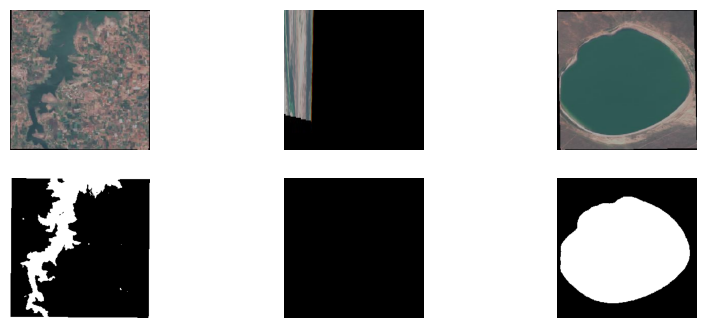

In [4]:
print("Number of images:", X.shape[0])
print("Image shape:", X.shape[1:])
print("Mask shape:", y.shape[1:])
print("Unique mask values:", np.unique(y))

plt.figure(figsize=(10,4))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])
    plt.axis("off")

    plt.subplot(2,3,i+4)
    plt.imshow(y[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()


# Splitting the dataset

In [5]:
# Train-Test split (80–20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Validation split (10% of train)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Train: (2044, 256, 256, 3)
Val:   (228, 256, 256, 3)
Test:  (569, 256, 256, 3)


# Data Augmentation

In [6]:
BATCH_SIZE = 8
seed = 42

data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train, seed=seed)
mask_datagen.fit(y_train, seed=seed)

def train_generator(batch_size=BATCH_SIZE, seed=seed):
    img_gen  = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
    mask_gen = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)
    while True:
        yield next(img_gen), next(mask_gen)

val_gen = ImageDataGenerator().flow(
    X_val, y_val, batch_size=BATCH_SIZE, shuffle=False
)


# SEGMENTATION METRICS (IoU & Dice)

In [7]:
def iou_metric(y_true, y_pred, smooth=1e-7):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

def f1_score(y_true, y_pred, smooth=1e-7):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    return (2 * tp + smooth) / (2 * tp + fp + fn + smooth)


# LOSS FUNCTION (BCE + DICE)

In [8]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)


# COMPILE FUNCTION & CALLBACKS

In [9]:
def compile_model(model, lr=1e-4):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=bce_dice_loss,
        metrics=["accuracy", iou_metric, dice_coef,f1_score]
    )
    return model

EPOCHS = 20
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
VAL_STEPS = len(X_val) // BATCH_SIZE

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_iou_metric",
    mode="max",
    patience=7,
    restore_best_weights=True
)


# MODEL ARCHITECTURES (DEFINED ONCE)

# Simple U-Net (Baseline Semantic Segmentation)

In [10]:
from tensorflow.keras import layers, Model

def simple_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(p1)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b = layers.Conv2D(64, 3, activation="relu", padding="same")(p2)

    # Decoder
    u2 = layers.UpSampling2D()(b)
    u2 = layers.Concatenate()([u2, c2])
    c3 = layers.Conv2D(32, 3, activation="relu", padding="same")(u2)

    u1 = layers.UpSampling2D()(c3)
    u1 = layers.Concatenate()([u1, c1])
    c4 = layers.Conv2D(16, 3, activation="relu", padding="same")(u1)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c4)

    return Model(inputs, outputs, name="Simple_UNet")


# Training and Evaluating the Model

In [11]:
# Building and compiling model
model_simple = simple_unet()
model_simple = compile_model(model_simple)

# Training model
history_simple = model_simple.fit(
    train_generator(),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=VAL_STEPS,
    callbacks=[early_stop],
    verbose=1
)

# Evaluating on test set
res_simple = model_simple.evaluate(X_test, y_test, verbose=0)

# Printing Evaluation Metrics
print(
    "Simple U-Net → "
    "IoU:", res_simple[2],
    "Dice:", res_simple[3],
    "F1-score:", res_simple[4]
)


Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6012 - dice_coef: 0.2969 - f1_score: 0.2969 - iou_metric: 0.2004 - loss: 1.3315

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


255/255 ━━━━━━━━━━━━━━━━━━━━ 55s 171ms/step - accuracy: 0.6015 - dice_coef: 0.2976 - f1_score: 0.2976 - iou_metric: 0.2009 - loss: 1.3307 - val_accuracy: 0.7788 - val_dice_coef: 0.5876 - val_f1_score: 0.5876 - val_iou_metric: 0.4267 - val_loss: 0.8908
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 161ms/step - accuracy: 0.7366 - dice_coef: 0.6703 - f1_score: 0.6703 - iou_metric: 0.5124 - loss: 0.8665 - val_accuracy: 0.7921 - val_dice_coef: 0.6402 - val_f1_score: 0.6402 - val_iou_metric: 0.4820 - val_loss: 0.8170
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.7528 - dice_coef: 0.6902 - f1_score: 0.6902 - iou_metric: 0.5372 - loss: 0.8195 - val_accuracy: 0.8023 - val_dice_coef: 0.6308 - val_f1_score: 0.6308 - val_iou_metric: 0.4715 - val_loss: 0.8058
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.7488 - dice_coef: 0.6800 - f1_score: 0.6800 - iou_metric: 0.5231 - loss: 0.8320 - val_accuracy: 0.8109 - val_dice_coef: 0.6426 - val_f1_score: 0.6426 - v

# Fully Convolutional Network (FCN)

In [12]:
def fcn_segmentation(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)

    x = layers.UpSampling2D()(x)
    x = layers.UpSampling2D()(x)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(x)

    return Model(inputs, outputs, name="FCN")


# Training and Evaluating the Model

In [13]:
# Building and compiling FCN model
model_fcn = fcn_segmentation()
model_fcn = compile_model(model_fcn)

# Training FCN model
history_fcn = model_fcn.fit(
    train_generator(),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=20,
    validation_data=val_gen,
    validation_steps=VAL_STEPS,
    callbacks=[early_stop],
    verbose=1
)

# Evaluating FCN model on test set
res_fcn = model_fcn.evaluate(X_test, y_test, verbose=0)

# Printing metrics
print(
    "FCN → "
    "IoU:", res_fcn[2],
    "Dice:", res_fcn[3],
    "F1-score:", res_fcn[4]
)


Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 50s 176ms/step - accuracy: 0.6450 - dice_coef: 0.2375 - f1_score: 0.2375 - iou_metric: 0.1630 - loss: 1.3715 - val_accuracy: 0.7704 - val_dice_coef: 0.5613 - val_f1_score: 0.5613 - val_iou_metric: 0.4001 - val_loss: 0.9271
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 81s 304ms/step - accuracy: 0.7302 - dice_coef: 0.6552 - f1_score: 0.6552 - iou_metric: 0.4960 - loss: 0.8857 - val_accuracy: 0.7860 - val_dice_coef: 0.6147 - val_f1_score: 0.6147 - val_iou_metric: 0.4558 - val_loss: 0.8495
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 45s 176ms/step - accuracy: 0.7587 - dice_coef: 0.6969 - f1_score: 0.6969 - iou_metric: 0.5441 - loss: 0.8046 - val_accuracy: 0.8024 - val_dice_coef: 0.6164 - val_f1_score: 0.6164 - val_iou_metric: 0.4573 - val_loss: 0.8269
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.7542 - dice_coef: 0.6845 - f1_score: 0.6845 - iou_metric: 0.5277 - loss: 0.8233 - val_accuracy: 0.8088 - val_dice_coef: 0.6290 - val_f1_score:

# Improved Attention + Residual U-Net

In [14]:
def residual_block(x, filters):
    shortcut = layers.Conv2D(filters, 1, padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.Add()([x, shortcut])
    return layers.Activation("relu")(x)

def attention_gate(x, g, filters):
    theta_x = layers.Conv2D(filters, 1, padding="same")(x)
    phi_g   = layers.Conv2D(filters, 1, padding="same")(g)
    add = layers.Add()([theta_x, phi_g])
    act = layers.Activation("relu")(add)
    att = layers.Conv2D(1, 1, activation="sigmoid")(act)
    return layers.Multiply()([x, att])
def improved_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    c1 = residual_block(inputs, 16)
    p1 = layers.MaxPooling2D()(c1)

    c2 = residual_block(p1, 32)
    p2 = layers.MaxPooling2D()(c2)

    c3 = residual_block(p2, 64)
    p3 = layers.MaxPooling2D()(c3)

    b = residual_block(p3, 128)

    u3 = layers.UpSampling2D()(b)
    a3 = attention_gate(c3, u3, 64)
    c6 = residual_block(layers.Concatenate()([u3, a3]), 64)

    u2 = layers.UpSampling2D()(c6)
    a2 = attention_gate(c2, u2, 32)
    c7 = residual_block(layers.Concatenate()([u2, a2]), 32)

    u1 = layers.UpSampling2D()(c7)
    a1 = attention_gate(c1, u1, 16)
    c8 = residual_block(layers.Concatenate()([u1, a1]), 16)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c8)

    return Model(inputs, outputs, name="Attention_ResUNet")


# Training and Evaluating the Model

In [15]:
# Building and compiling Improved U-Net model
model_improved = improved_unet()
model_improved = compile_model(model_improved)

# Training Improved U-Net model
history_improved = model_improved.fit(
    train_generator(),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=20,
    validation_data=val_gen,
    validation_steps=VAL_STEPS,
    callbacks=[early_stop],
    verbose=1
)

# Evaluating Improved U-Net on test set
res_improved = model_improved.evaluate(X_test, y_test, verbose=0)

# Printing metrics
print(
    "Improved U-Net → "
    "IoU:", res_improved[2],
    "Dice:", res_improved[3],
    "F1-score:", res_improved[4]
)


Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 69s 192ms/step - accuracy: 0.6780 - dice_coef: 0.4286 - f1_score: 0.4286 - iou_metric: 0.3154 - loss: 1.1487 - val_accuracy: 0.8230 - val_dice_coef: 0.6701 - val_f1_score: 0.6701 - val_iou_metric: 0.5118 - val_loss: 0.7602
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 57s 179ms/step - accuracy: 0.7723 - dice_coef: 0.7087 - f1_score: 0.7087 - iou_metric: 0.5558 - loss: 0.7725 - val_accuracy: 0.8377 - val_dice_coef: 0.7067 - val_f1_score: 0.7067 - val_iou_metric: 0.5541 - val_loss: 0.6934
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 45s 178ms/step - accuracy: 0.7750 - dice_coef: 0.7029 - f1_score: 0.7029 - iou_metric: 0.5532 - loss: 0.7652 - val_accuracy: 0.8305 - val_dice_coef: 0.7103 - val_f1_score: 0.7103 - val_iou_metric: 0.5583 - val_loss: 0.6948
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 45s 176ms/step - accuracy: 0.7838 - dice_coef: 0.7198 - f1_score: 0.7198 - iou_metric: 0.5729 - loss: 0.7400 - val_accuracy: 0.8480 - val_dice_coef: 0.7003 - val_f1_score:

# DeepLabV3-Lite (Atrous Convolution)

In [16]:
def deeplab_v3_lite(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)

    # ASPP (Atrous Spatial Pyramid Pooling)
    conv1  = layers.Conv2D(128, 1, dilation_rate=1,  padding="same", activation="relu")(x)
    conv6  = layers.Conv2D(128, 3, dilation_rate=6,  padding="same", activation="relu")(x)
    conv12 = layers.Conv2D(128, 3, dilation_rate=12, padding="same", activation="relu")(x)

    x = layers.Concatenate()([conv1, conv6, conv12])
    x = layers.Conv2D(128, 1, activation="relu")(x)

    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(x)

    return Model(inputs, outputs, name="DeepLabV3_Lite")


# Training and Evaluating the Model

In [17]:
# Building and compiling DeepLabV3-Lite model
model_deeplab = deeplab_v3_lite()
model_deeplab = compile_model(model_deeplab)

# Training DeepLabV3-Lite model
history_deeplab = model_deeplab.fit(
    train_generator(),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=20,
    validation_data=val_gen,
    validation_steps=VAL_STEPS,
    callbacks=[early_stop],
    verbose=1
)

# Evaluating DeepLabV3-Lite on test set
res_deeplab = model_deeplab.evaluate(X_test, y_test, verbose=0)

# Printing metrics
print(
    "DeepLabV3-Lite → "
    "IoU:", res_deeplab[2],
    "Dice:", res_deeplab[3],
    "F1-score:", res_deeplab[4]
)


Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 70s 221ms/step - accuracy: 0.6513 - dice_coef: 0.3156 - f1_score: 0.3156 - iou_metric: 0.2285 - loss: 1.2850 - val_accuracy: 0.8032 - val_dice_coef: 0.6531 - val_f1_score: 0.6531 - val_iou_metric: 0.4943 - val_loss: 0.7884
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 62s 211ms/step - accuracy: 0.7579 - dice_coef: 0.6978 - f1_score: 0.6978 - iou_metric: 0.5425 - loss: 0.8044 - val_accuracy: 0.8050 - val_dice_coef: 0.6886 - val_f1_score: 0.6886 - val_iou_metric: 0.5325 - val_loss: 0.7504
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 53s 209ms/step - accuracy: 0.7670 - dice_coef: 0.7082 - f1_score: 0.7082 - iou_metric: 0.5574 - loss: 0.7751 - val_accuracy: 0.8277 - val_dice_coef: 0.6990 - val_f1_score: 0.6990 - val_iou_metric: 0.5448 - val_loss: 0.7048
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 53s 207ms/step - accuracy: 0.7618 - dice_coef: 0.6958 - f1_score: 0.6958 - iou_metric: 0.5437 - loss: 0.7968 - val_accuracy: 0.8332 - val_dice_coef: 0.6813 - val_f1_score:

# RESULTS COMPARISON TABLE

In [18]:
results = {
    "Simple U-Net": {
        "Accuracy": res_simple[1],
        "IoU":      res_simple[2],
        "Dice":     res_simple[3],
        "F1-score": res_simple[4]
    },
    "FCN": {
        "Accuracy": res_fcn[1],
        "IoU":      res_fcn[2],
        "Dice":     res_fcn[3],
        "F1-score": res_fcn[4]
    },
    "DeepLabV3-Lite": {
        "Accuracy": res_deeplab[1],
        "IoU":      res_deeplab[2],
        "Dice":     res_deeplab[3],
        "F1-score": res_deeplab[4]
    },
    "Attention-ResUNet": {
        "Accuracy": res_improved[1],
        "IoU":      res_improved[2],
        "Dice":     res_improved[3],
        "F1-score": res_improved[4]
    }
}


# Converting to Table (DataFrame)

In [19]:
import pandas as pd

df_results = pd.DataFrame(results).T
df_results = df_results.round(4)

df_results


,Accuracy,IoU,Dice,F1-score
Simple U-Net,0.8390,0.5826,0.7346,0.7346
FCN,0.8152,0.5770,0.7305,0.7305
DeepLabV3-Lite,0.8533,0.6363,0.7764,0.7764
Attention-ResUNet,0.8741,0.6670,0.7988,0.7988


# Saving as csv

In [20]:
df_results.to_csv("semantic_segmentation_results.csv")


# BAR PLOT – MODEL COMPARISON (ACCURACY, IoU, DICE, F1-Score)

# VISUALIZATION FIGURE (IMAGE vs GT vs PREDICTION)

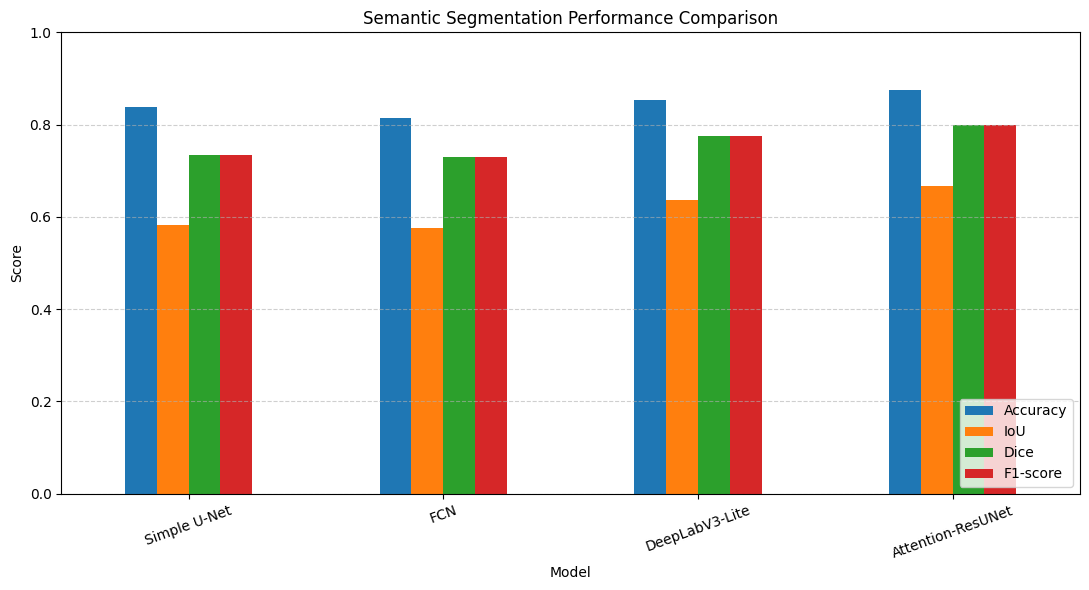

In [21]:
import matplotlib.pyplot as plt


metrics = ["Accuracy", "IoU", "Dice", "F1-score"]

df_results[metrics].plot(
    kind="bar",
    figsize=(11, 6)
)

plt.title("Semantic Segmentation Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=20)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# BAR PLOT - Only F1-Score

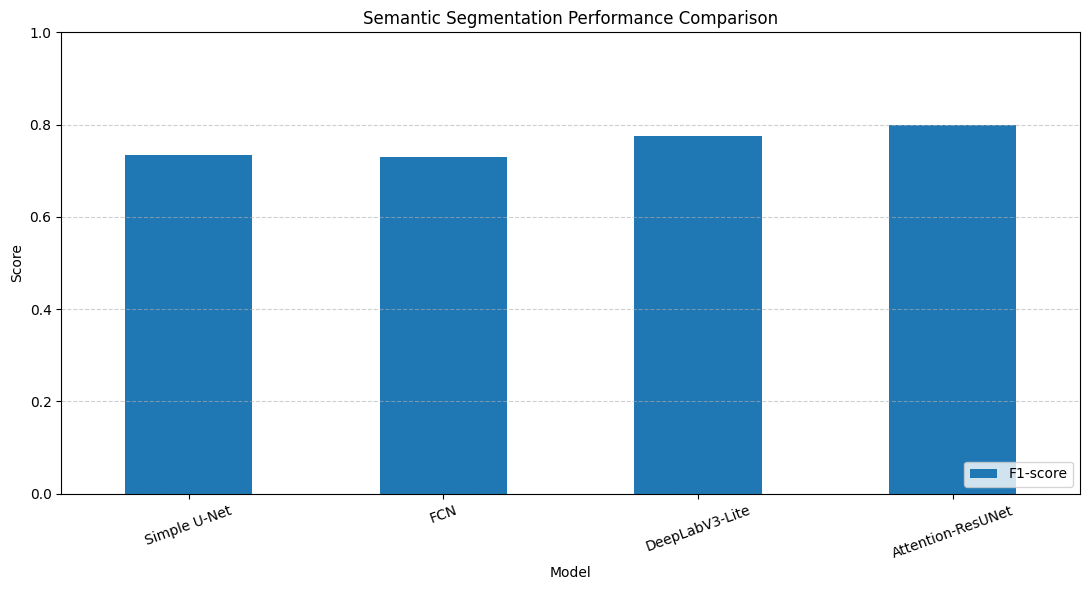

In [22]:
import matplotlib.pyplot as plt


metrics = ["F1-score"]

df_results[metrics].plot(
    kind="bar",
    figsize=(11, 6)
)

plt.title("Semantic Segmentation Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=20)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Computing Metrics for ONE Image

In [23]:
def compute_metrics_single(y_true, y_pred):
    acc  = np.mean(y_true == y_pred)
    iou  = iou_metric(y_true[np.newaxis,...], y_pred[np.newaxis,...]).numpy()
    dice = dice_coef(y_true[np.newaxis,...], y_pred[np.newaxis,...]).numpy()
    return acc, iou, dice


# Visualization

In [24]:
def visualize_predictions_with_metrics(model, X, y, threshold=0.4, n=5):
    preds = model.predict(X[:n])
    preds = (preds > threshold).astype(np.float32)

    plt.figure(figsize=(14, 4*n))

    for i in range(n):
        acc, iou, dice = compute_metrics_single(
            y[i].squeeze(), preds[i].squeeze()
        )

        # Original Image
        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(X[i])
        plt.title("Satellite Image")
        plt.axis("off")

        # Ground Truth
        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(y[i].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Prediction
        plt.subplot(n, 3, i*3 + 3)
        plt.imshow(preds[i].squeeze(), cmap="gray")
        plt.title(
            f"Prediction\nAcc={acc:.2f}, IoU={iou:.2f}, Dice={dice:.2f}"
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Running Visualization (for BEST MODEL)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


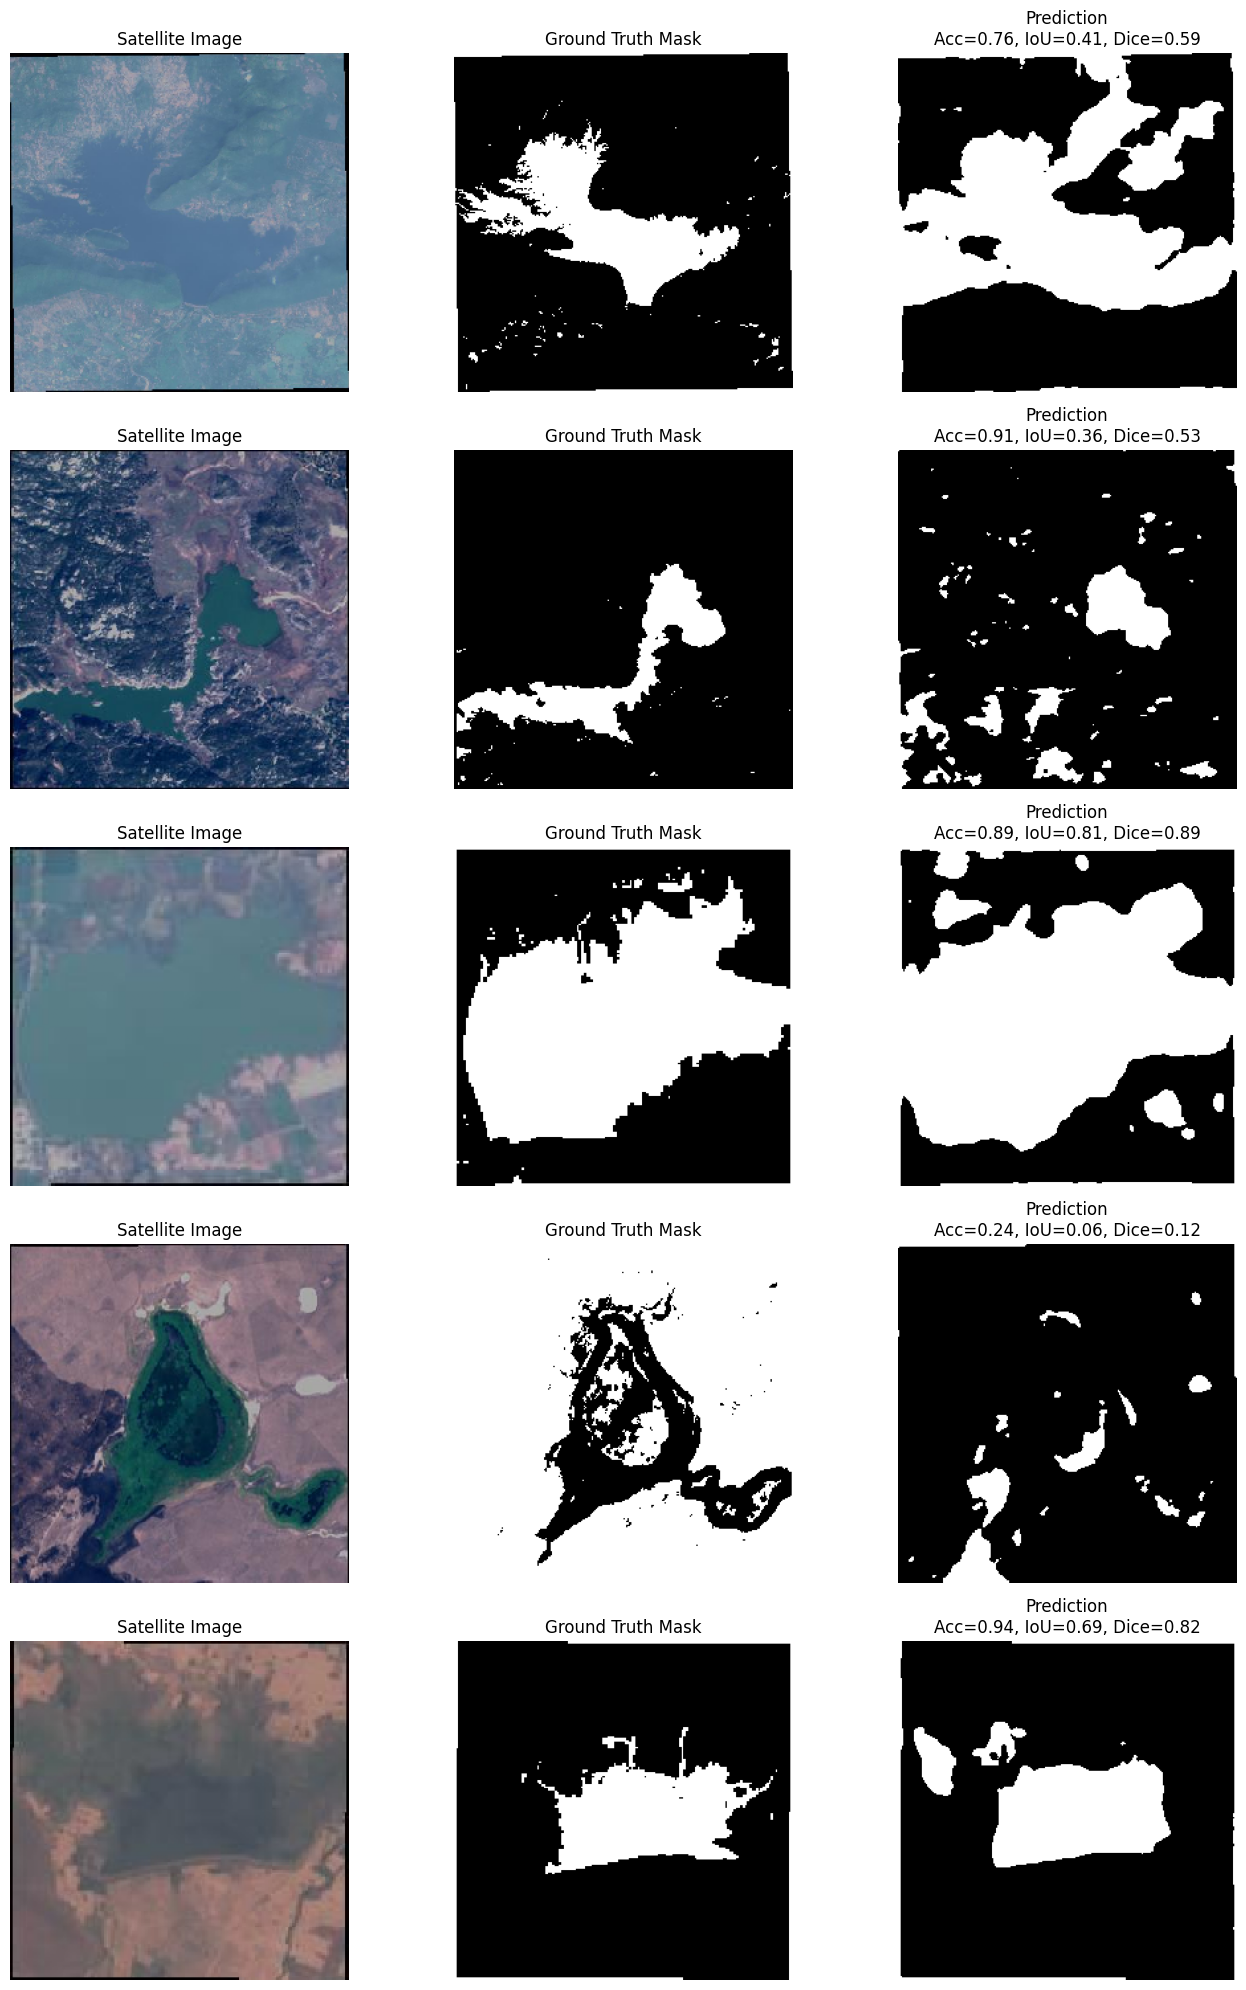

In [25]:
visualize_predictions_with_metrics(
    model_improved,
    X_test,
    y_test,
    threshold=0.4,
    n=5
)


# ACCURACY vs IoU DISCREPANCY

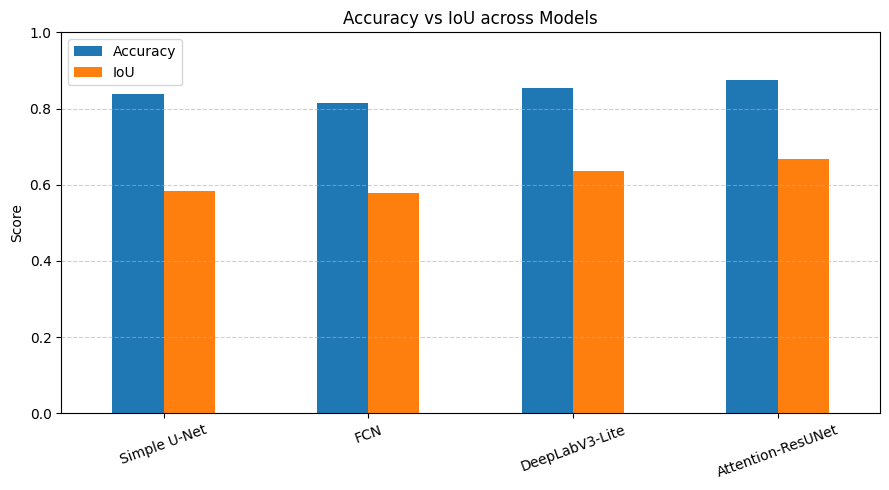

In [26]:
df_results[["Accuracy", "IoU"]].plot(
    kind="bar",
    figsize=(9, 5)
)

plt.title("Accuracy vs IoU across Models")
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#  F1-Score vs IoU DISCREPANCY

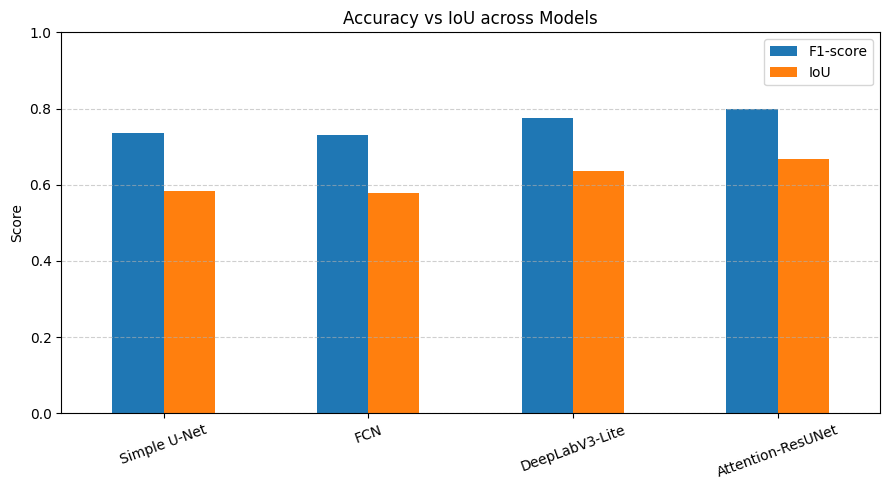

In [29]:
df_results[["F1-score", "IoU"]].plot(
    kind="bar",
    figsize=(9, 5)
)

plt.title("Accuracy vs IoU across Models")
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
